In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertTokenizer, DistilBertModel
import os
import re
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

# imports and check if cuda is avaiable

NUM_CLASSES = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load image model

image_model = models.efficientnet_b2(weights=None)

in_features = image_model.classifier[1].in_features

image_model.classifier = nn.Sequential(
    nn.Linear(in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),

    nn.Linear(512, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Dropout(0.3),

    nn.Linear(128, NUM_CLASSES),
)

image_model.load_state_dict(torch.load("best_image_model.pth", map_location=device))

image_model = image_model.to(device)
image_model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# Load text model

class DistilBERTClassifier(nn.Module):

    def __init__(self, num_classes):
        super().__init__()

        self.distilbert = DistilBertModel.from_pretrained(
            "distilbert-base-uncased"
        )

        self.dropout = nn.Dropout(0.3)

        self.classifier = nn.Linear(
            self.distilbert.config.hidden_size,
            num_classes
        )

    def forward(self, input_ids, attention_mask):

        outputs = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        cls_output = outputs.last_hidden_state[:, 0]

        x = self.dropout(cls_output)

        return self.classifier(x)


text_model = DistilBERTClassifier(NUM_CLASSES)

checkpoint = torch.load("best_text_model.pt", map_location=device)

text_model.load_state_dict(checkpoint["model_state_dict"])
text_model = text_model.to(device)
text_model.eval()

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertModel LOAD REPORT from: distilbert-base-uncased
Key                     | Status     |  | 
------------------------+------------+--+-
vocab_layer_norm.weight | UNEXPECTED |  | 
vocab_transform.weight  | UNEXPECTED |  | 
vocab_layer_norm.bias   | UNEXPECTED |  | 
vocab_projector.bias    | UNEXPECTED |  | 
vocab_transform.bias    | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:


class MultimodalDataset(Dataset):

    def __init__(self, image_dir, transform, tokenizer, max_len=24):

        self.image_dataset = datasets.ImageFolder(image_dir, transform=transform)
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.image_dataset)

    def __getitem__(self, idx):

        image, label = self.image_dataset[idx]

        path = self.image_dataset.samples[idx][0]
        filename = os.path.basename(path)

        text = os.path.splitext(filename)[0]
        text = text.replace('_', ' ')
        text = re.sub(r'\d+', '', text)
        ######## Talc version ###########
        # encoding = tokenizer.encode_plus(
        #     text,
        #     add_special_tokens=True,
        #     max_length=self.max_len,
        #     padding='max_length',
        #     truncation=True,
        #     return_attention_mask=True,
        #     return_tensors='pt'
        # )

        # return {
        #     "image": image,
        #     "input_ids": encoding["input_ids"].squeeze(),
        #     "attention_mask": encoding["attention_mask"].squeeze(),
        #     "label": label
        # }
        ######### Colab version ########
        encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
        )

        return {
            "image": image,
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "label": label
        }

In [ ]:
transform_test = transforms.Compose([
    transforms.Resize((288, 288)),
    transforms.CenterCrop(288),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    ),
])



TEST_PATH=  "/content/drive/MyDrive/dataTest"
test_dataset = MultimodalDataset(
    TEST_PATH,
    transform_test,
    tokenizer
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False
)

Confusion Matrix function

In [ ]:


def plot_confusion_matrix(y_true, y_pred,
                          title='Confusion Matrix',
                          normalize=False):
    class_names = ['Black','Blue','Green','TTR']
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        fmt = ".2f"
    else:
        fmt = "d"

    plt.figure(figsize=(8,6))

    sns.heatmap(
        cm,
        annot=True,
        fmt=fmt,
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')

    plt.show()


Misclassification function


In [ ]:


def show_misclassified(image_model, text_model, test_loader, device, max_show=8):
    class_names = ['Black','Blue','Green','TTR']
    image_model.eval()
    text_model.eval()

    shown = 0
    plt.figure(figsize=(12,6))

    with torch.no_grad():

        for batch in test_loader:

            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            # logits
            image_logits = image_model(images)
            text_logits = text_model(input_ids, attention_mask)

            # probabilities
            image_probs = F.softmax(image_logits, dim=1)
            text_probs = F.softmax(text_logits, dim=1)

            # confidence selection
            image_conf, image_pred = torch.max(image_probs, dim=1)
            text_conf, text_pred = torch.max(text_probs, dim=1)

            use_image = image_conf > text_conf
            final_pred = torch.where(use_image, image_pred, text_pred)

            for i in range(len(final_pred)):

                if final_pred[i] != labels[i] and shown < max_show:

                    img = images[i].cpu().permute(1,2,0)

                    plt.subplot(2,4,shown+1)
                    plt.imshow(img)
                    plt.axis("off")

                    pred_name = class_names[final_pred[i]]
                    true_name = class_names[labels[i]]

                    plt.title(f"Prediction:{pred_name}\nAccurate:{true_name}")

                    shown += 1

                if shown >= max_show:
                    break

            if shown >= max_show:
                break

    plt.suptitle("Misclassified Examples")
    plt.show()

In [ ]:
import torch.nn.functional as F
import numpy as np

all_preds = []
all_labels = []

image_model.eval()
text_model.eval()

with torch.no_grad():

    for batch in test_loader:

        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Get logits
        image_logits = image_model(images)
        text_logits = text_model(input_ids, attention_mask)

        # Convert to probabilities
        image_probs = F.softmax(image_logits, dim=1)
        text_probs = F.softmax(text_logits, dim=1)

        # Get confidence + prediction
        image_conf, image_pred = torch.max(image_probs, dim=1)
        text_conf, text_pred = torch.max(text_probs, dim=1)

        # CONFIDENCE SELECTION
        # Check which model has a higher confidence in its result and use that result
        # For example image model output (0.7,0.2,0.1,0.1), text model output (0.6,0.2,0.2,0); the code will choose the result of the image model
        use_image = image_conf > text_conf

        final_pred = torch.where(use_image, image_pred, text_pred)

        all_preds.extend(final_pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())



In [ ]:
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
############## Confidence Fusion Accuracy Result##########
print("Confidence Fusion Accuracy:", accuracy)

Confidence Fusion Accuracy: 0.8257575757575758


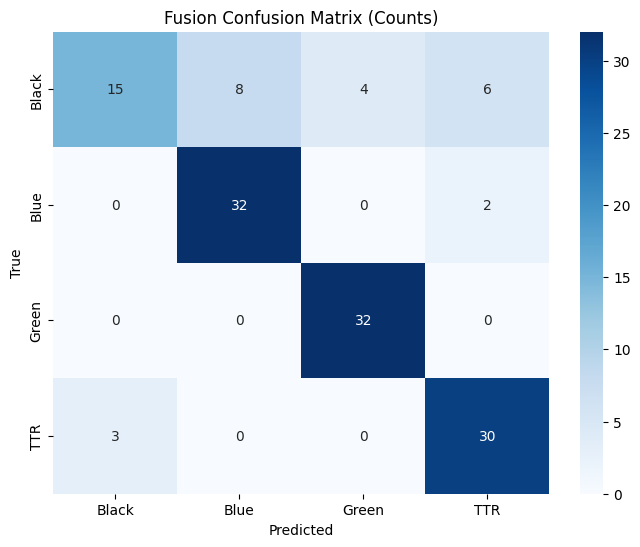

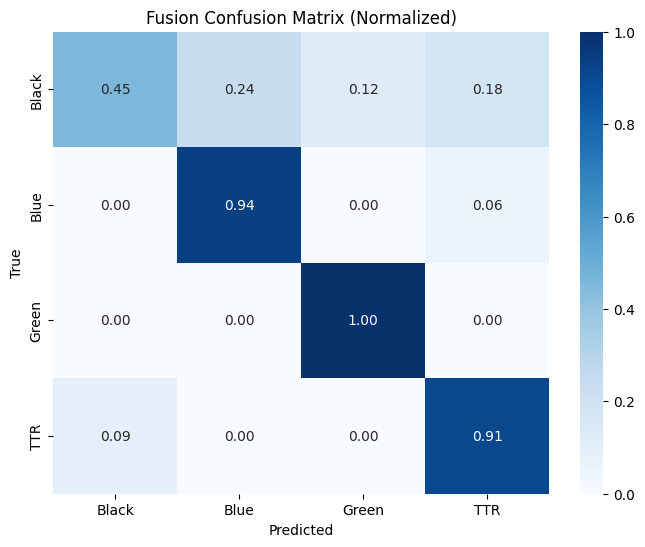

In [ ]:

#########Funstion Confusion Matrix(Counts) and Fustion Confusion Matrix(Normalized)#######
plot_confusion_matrix(
    all_labels,
    all_preds,
    "Fusion Confusion Matrix (Counts)",
    normalize=False
)

plot_confusion_matrix(
    all_labels,
    all_preds,
    "Fusion Confusion Matrix (Normalized)",
    normalize=True
)


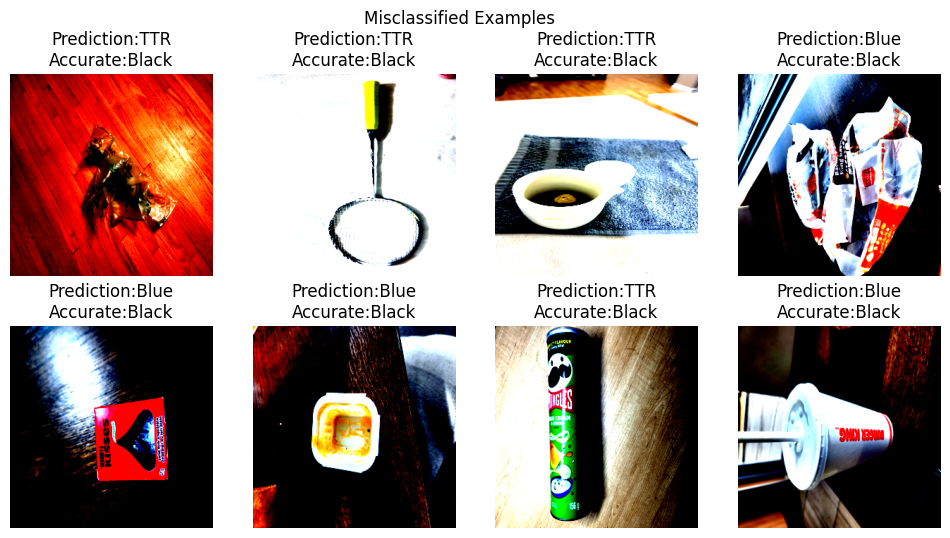

In [ ]:
show_misclassified(image_model,text_model,test_loader,device)

In [ ]:
import torch.nn.functional as F
import numpy as np

all_preds = []
all_labels = []

image_model.eval()
text_model.eval()

with torch.no_grad():

    for batch in test_loader:

        images = batch["image"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        # Get logits
        image_logits = image_model(images)
        text_logits = text_model(input_ids, attention_mask)

        # Convert to probabilities
        image_probs = F.softmax(image_logits, dim=1)
        text_probs = F.softmax(text_logits, dim=1)

        # FUSION (average probabilities)
        fused_probs = (image_probs + text_probs) / 2

        # Final prediction
        fused_pred = torch.argmax(fused_probs, dim=1)

        all_preds.extend(fused_pred.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

In [ ]:
accuracy = np.mean(np.array(all_preds) == np.array(all_labels))

print("Confidence Fusion Accuracy:", accuracy)